In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

import sentencepiece as spm

In [2]:
df = pd.read_csv("python_solved.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

In [3]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()
df = df[(df.n_lines >= 30) & (df.n_lines <= 200)] # there should be enough loc for 2D convolution
df.n_lines.describe()

count    51429.000000
mean        59.333528
std         28.515640
min         30.000000
25%         39.000000
50%         51.000000
75%         71.000000
max        200.000000
Name: n_lines, dtype: float64

In [4]:
df

,year,username,flines,n_lines
0,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")...",124
1,2008,rspeer,"#!/usr/bin/env python2.5\n import math, sys, o...",120
2,2008,rspeer,"#!/usr/bin/env python2.5\n import math, sys, o...",103
3,2008,MTWTFFF,import sys\n import pprint\n import random\n \...,99
4,2008,jonathantan86,"FI = 'A-large.in'\n \n def case(fi, fo, n):\n ...",78
...,...,...,...,...
76791,2017,sonudoo,"import sys,operator\n sys.stdin = open('stdin....",40
76792,2017,KennyCz,import sys\n import operator\n \n \n def greed...,80
76793,2017,KennyCz,"import sys\n import math\n \n \n def answer(N,...",31
76794,2017,Fantoccini,\n import math\n \n def solve(fin):\n part...,39


In [5]:
# average lines of code for non-empty lines

def avg_loc(file):
    lines = file.split('\n')
    s = 0
    c = 0
    for line in lines:
        if line: # if line is not empty
            s += len(line)
            c += 1
    return s/c


df["avg_loc"] = df.flines.apply(avg_loc)

In [6]:
df.avg_loc.describe()

count    51429.000000
mean        24.433282
std         27.861530
min          6.774194
25%         20.232558
50%         23.295918
75%         26.685714
max       2304.270270
Name: avg_loc, dtype: float64

In [7]:
def max_loc(file):
    lines = file.split('\n')
    max_ch = 0
    for line in lines:
        if len(line) > max_ch:
            max_ch = len(line)
    return max_ch

df["max_loc"] = df.flines.apply(max_loc)

In [8]:
df.max_loc.describe()

count    51429.000000
mean       103.815765
std       1288.302951
min         20.000000
25%         58.000000
50%         69.000000
75%         82.000000
max      99978.000000
Name: max_loc, dtype: float64

In [9]:
df = df[df.max_loc <= 120]

In [10]:
df.max_loc.describe()

count    49260.000000
mean        69.767276
std         17.317103
min         20.000000
25%         57.000000
50%         68.000000
75%         80.000000
max        120.000000
Name: max_loc, dtype: float64

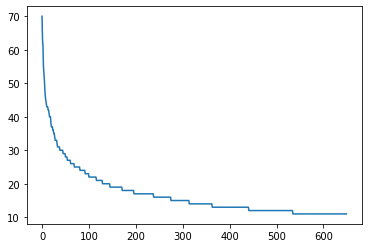

In [11]:
plt.plot(df.username.value_counts().values[0: 650])

In [12]:
users = df.username.value_counts()[0:650].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,avg_loc,max_loc
0,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")...",124,17.483871,77
5,2008,Klinck,import sys\n import math\n \n MOD = 10007\n \n...,105,19.428571,68
6,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,40,27.975000,94
7,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,47,17.787234,57
8,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,51,20.568627,57


Input size - 200x120

In [13]:
def vectorize(file):
    lines = file.split('\n')
    res = np.zeros((200, 120), dtype=int)
    for i in range(len(lines)):
        if i >= 200:
            print("error", i, lines[i])
            break
        line = lines[i]
        for j in range(len(line)):
            res[i][j] = ord(line[j])
    return res.tolist()


In [14]:
X = df.flines.apply(vectorize).values
X = np.array([np.array(x) for x in X])
X = X.reshape(-1, 200, 120)

error 200 
error 200 
error 200 
error 200                  print "\n\n"


In [15]:
y = np.array(df.username)
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

In [16]:
y_1d = np.argmax(y, axis = 1)

In [17]:
import tensorflow_addons as tfa

In [31]:
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, accuracy_score


class TestCallback(callbacks.Callback):
    def __init__(self, X, y, threshold=0.2):
        self.threshold = threshold
        index = np.where(y < 25)[0]
        self.X = X[index]
        self.y = y[index]
        self.scores = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs=None):
        #(model, new_X, new_y, threshold=0.2, printing=0):
        transformed_X = self.model.predict(self.X)
    #     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
        
        y_pred = []
        y_true = []
        for i in range(self.X.shape[0]):
            for j in range(i, self.X.shape[0]):
                if np.mean((transformed_X[i] - transformed_X[j])**2) <= self.threshold:
                    y_pred.append(1)
                else:
                    y_pred.append(0)

                if self.y[i] == self.y[j]:
                    y_true.append(1)
                else:
                    y_true.append(0)
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)

        score = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
#         if printing:
#             print(cm)
#             print("totoal predicted as 1:", sum(y_pred), 
#                   "\ntotoal real 1:", sum(y_true), 
#                   "\ntotal examples", y_true.shape)
            
        recall = cm[1][1]/sum(y_true)
        
        self.scores.append(score)
        self.recalls.append(recall)
        print("accuracy:", round(score, 4), "recall:", round(recall, 4))
        return score, recall
    
    def return_results(self):
        return {"scores": self.scores, "recalls": self.recalls}



In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X.reshape((-1, 200*120))).reshape((-1, 200, 120))

In [32]:
tfa_model = keras.Sequential()
tfa_model.add(layers.Conv2D(16, 4, activation="relu", padding="same"))
tfa_model.add(layers.MaxPooling2D(pool_size=4))
tfa_model.add(layers.Dropout(0.5))
tfa_model.add(layers.Conv2D(16, 4, activation="relu", padding="same")) 
tfa_model.add(layers.MaxPooling2D(pool_size=4))
# tfa_model.add(layers.Dropout(0.5))
# tfa_model.add(layers.Conv2D(16, 4, activation="relu", padding="same")) 
# tfa_model.add(layers.MaxPooling1D(pool_size=4))
tfa_model.add(layers.Dropout(0.5))
tfa_model.add(layers.Flatten())
tfa_model.add(layers.Dense(128, activation="relu"))
tfa_model.add(layers.LayerNormalization(axis=1))
tfa_model.add(layers.Dropout(0.5))
tfa_model.add(layers.Dense(50, activation="relu"))


In [33]:

tfa_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2)
)

In [ ]:
batch_size = 128
epochs = 200
steps_per_epoch = int(X.shape[0]/batch_size)
X = X.reshape((-1, 200, 120, 1))

lr_schedule = callbacks.ReduceLROnPlateau(monitor="loss", actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=7, restore_best_weights=True)
test_cb = TestCallback(X, y_1d)

history = tfa_model.fit(x=X, y=y_1d, epochs = epochs, 
                         validation_data = (X, y_1d),
                         steps_per_epoch=steps_per_epoch,
                         verbose=1, 
                         callbacks=[lr_schedule, early_stopping, test_cb])

Epoch 1/200
86/86 [==============================] - 74s 852ms/step - loss: 0.1050 - val_loss: 0.3105
accuracy: 0.9574 recall: 0.1083
Epoch 2/200
86/86 [==============================] - 71s 824ms/step - loss: 0.1709 - val_loss: 1.0545
accuracy: 0.9574 recall: 0.1081
Epoch 3/200
86/86 [==============================] - 72s 844ms/step - loss: 0.3385 - val_loss: 0.9962
accuracy: 0.9574 recall: 0.1081
Epoch 4/200
86/86 [==============================] - 73s 851ms/step - loss: 0.2666 - val_loss: 1.0253
accuracy: 0.9574 recall: 0.1081
Epoch 5/200
86/86 [==============================] - 73s 852ms/step - loss: 0.3188 - val_loss: 1.0392
accuracy: 0.9574 recall: 0.1081
Epoch 6/200
86/86 [==============================] - 74s 860ms/step - loss: 0.3038 - val_loss: 1.0408
accuracy: 0.9574 recall: 0.1081
Epoch 7/200
86/86 [==============================] - ETA: 0s - loss: 0.3566